In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [56]:
df = pd.read_csv("train.csv")
# df["day"] = pd.to_datetime(df["day"])

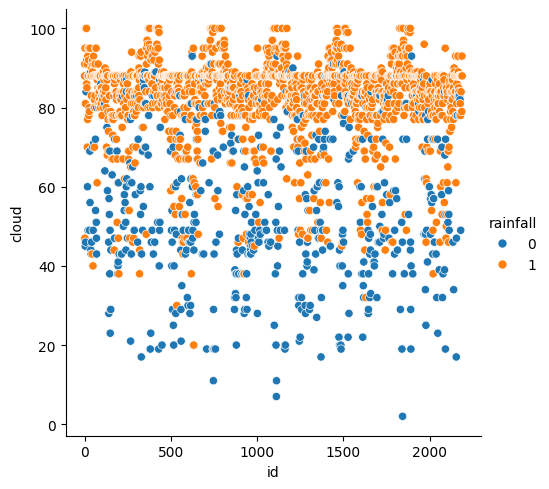

In [57]:
sns.relplot(data=df, x="id", y="cloud", hue="rainfall")

In [58]:
print(df.shape)
print(df.info())

(2190, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB
None


In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2190.0,1094.500000,632.342866,0.0,547.250,1094.50,1641.750,2189.0
day,2190.0,179.948402,105.203592,1.0,89.000,178.50,270.000,365.0
pressure,2190.0,1013.602146,5.655366,999.0,1008.600,1013.00,1017.775,1034.6
maxtemp,2190.0,26.365799,5.654330,10.4,21.300,27.80,31.200,36.0
temparature,2190.0,23.953059,5.222410,7.4,19.300,25.50,28.400,31.5
mintemp,2190.0,22.170091,5.059120,4.0,17.700,23.85,26.400,29.8
dewpoint,2190.0,20.454566,5.288406,-0.3,16.800,22.15,25.000,26.7
humidity,2190.0,82.036530,7.800654,39.0,77.000,82.00,88.000,98.0
cloud,2190.0,75.721918,18.026498,2.0,69.000,83.00,88.000,100.0
sunshine,2190.0,3.744429,3.626327,0.0,0.400,2.40,6.800,12.1


<Axes: >

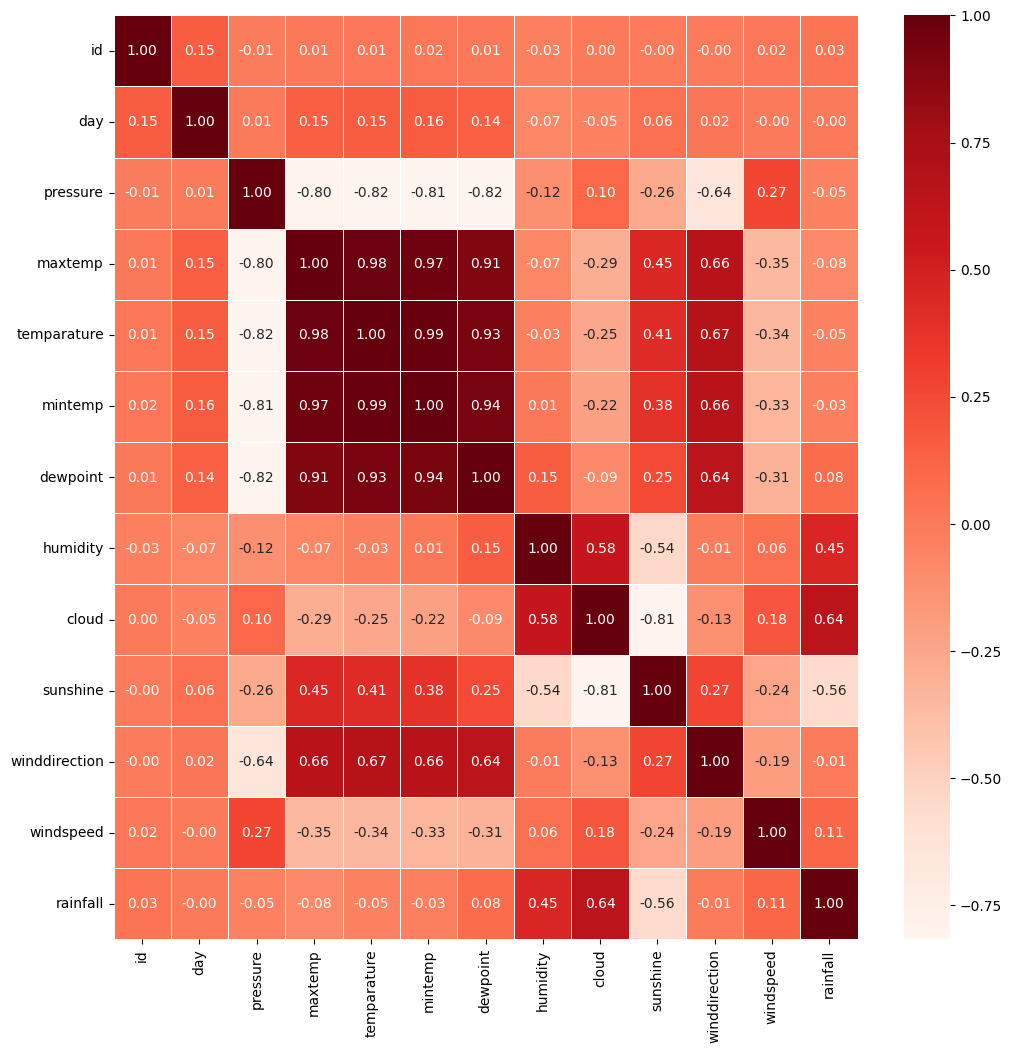

In [60]:
correlacion = df.corr(numeric_only=True)
plt.figure(figsize=(12, 12))
sns.heatmap(correlacion,cmap="Reds", linewidths=0.5,annot=True, fmt=".2f")

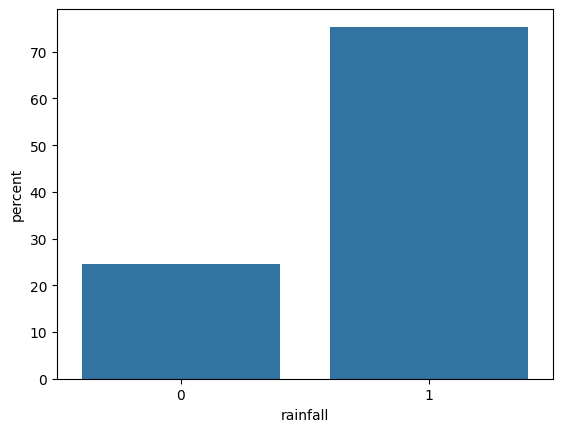

In [61]:
sns.countplot(data=df,x="rainfall",stat="percent")
plt.show()

In [62]:
pd.DataFrame(df["rainfall"].value_counts())

,count
rainfall,
1,1650
0,540


In [63]:
def fProcesamiento (df):
    df = df.copy()
    #Pongo el id sobre day para hacerle bypass a los outliers:
    df.day=df.id.apply(lambda x: x%365+1)
    
    #Columnas sacadas a partir de exploracion visual:
    df["rainperiod"] = df["day"].apply(lambda x: 1 if (x>=85 and x<=140) else 0)
    df["cloud75"] = df["cloud"].apply(lambda x: 1 if x >=75 else 0)
    
    #Columnas relacionadas con cloud:
    df["cloudxhumidity"] = df["cloud"] * df["humidity"]
    df["cloud_sun"] = df["cloud"] + df["sunshine"]
    df["cloudxhumidity_sun"] = df["cloud"] * df["humidity"] + df["sunshine"]
    df["cloud_windspeed"] = df["cloud"] + df["windspeed"]
    df["cloud_temperature"] = df["cloud"] + df["temparature"]

    #Columnas relacionadas con el tiempo:
    df["day_sen"] = np.sin(2 * np.pi * df["day"]/365)
    df["day_cos"] = np.cos(2 * np.pi * df["day"]/365)
    
    #Columnas random:
    df["humidity_dewpoint"] = df["humidity"] + df["dewpoint"]
    df["humidity_mintemp"] = df["humidity"] + df["mintemp"]
    df["dewpoint_mintemp"] = df["dewpoint"] + df["mintemp"]
    df["windtot"] = df["windspeed"]*df["winddirection"]

    #Ultimas adiciones:
    df["humidity5"] = df["humidity"].shift(5)
    df["sun"] = pd.cut(df["sunshine"], bins=3, labels=["Bajo","Medio", "Alto"])
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(df[['sun']])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['sun']))
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(columns="sun")
    #Tratamiento de los nan:
    df = df.fillna(df.mean())
    
    #Columnas seleccionadas para el dataframe final:
    x = df.drop(columns=["id","maxtemp","mintemp"])

    return x

In [64]:
df = fProcesamiento(df)

In [65]:
from sklearn.feature_selection import mutual_info_classif

# Calcular la información mutua
mi_scores = mutual_info_classif(df.drop("rainfall", axis=1), df["rainfall"])

# Crear una Serie de Pandas con los nombres de las columnas
mi_series = pd.Series(mi_scores, index=df.drop("rainfall", axis=1).columns)

# Ordenar de mayor a menor importancia
mi_series = mi_series.sort_values(ascending=False)

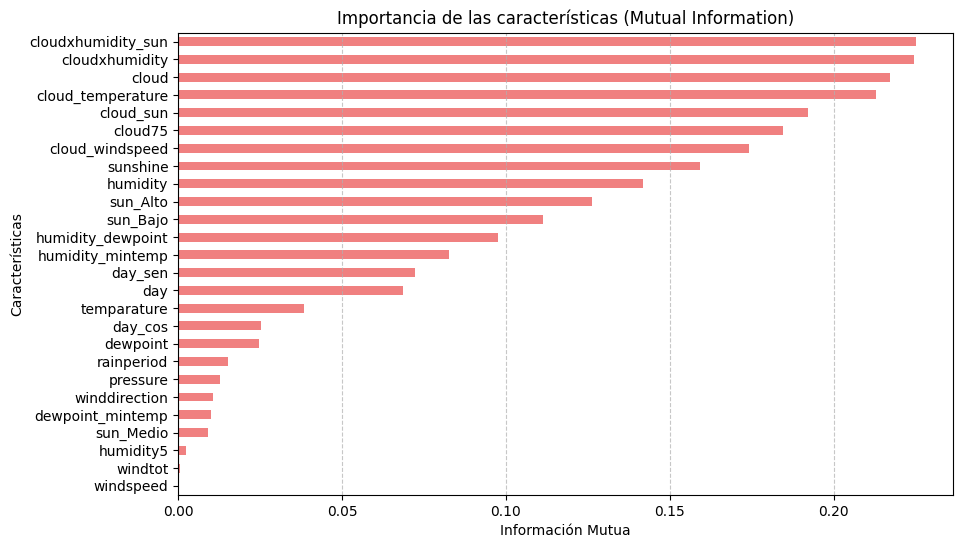

In [66]:
plt.figure(figsize=(10, 6))
mi_series.sort_values(ascending=True).plot(kind="barh", color="lightcoral")
plt.title("Importancia de las características (Mutual Information)")
plt.xlabel("Información Mutua")
plt.ylabel("Características")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()